# Coding Controllers 4.  PID Control

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import control
import pandas as pd

## Proportional-Integral Control

A simple velocity form of Proportional-Integral control is an example of a controller with internal state. In velocity form,

$$MV_{k} = MV_{k-1} + K_p (e_k - e_{k-1}) + K_iT_se_k$$

where $e_k$ is the difference between setpoint and measured process variable

$$e_k = SP_k - PV_k$$

$K_p$ and $K_i$ are control constants, and $T_s$ is the sampling time. To prevent windup of the integral term, a PI algorithm will typically enforce upper and lower bounds on the value of $MV$. 

The following cell provides a direct implementation of this algorithm as a Python generator.

In [5]:
def PI(Kp, Ki, b=1):
    """Proportional Integral Control."""
    t = 0
    e = 0
    MV = 0
    while True:
        # store prior values before yielding
        t_prev = t
        e_prev = e
        MV_prev = MV
        
        # yield
        PV, SP, t = yield MV

        # PI control algorithm
        e = b*SP - PV
        MV = MV_prev + Kp*(e - e_prev) + Ki*(t - t_prev)*(SP - PV)
        
        # prevent integral windup
        MV = max(0, min(100, MV))

### Simulation

Text(0.5, 1.0, 'Temperature Setpoint')

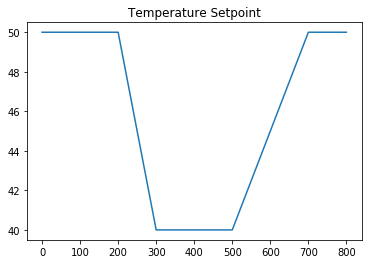

In [6]:
def Tsp(t):
    tp = [  0,  200,  300,  500,  700, 9999]
    Tp = [ 50,   50,   40,   40,   50,   50]
    return np.interp(t, tp, Tp)

t = np.linspace(0, 800, 801)
plt.plot(t, Tsp(t))
plt.title('Temperature Setpoint')

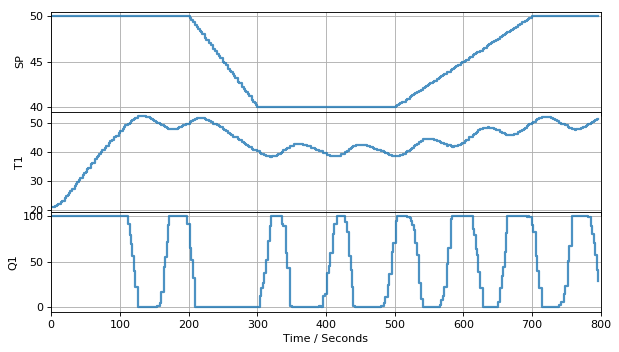

TCLab Model disconnected successfully.


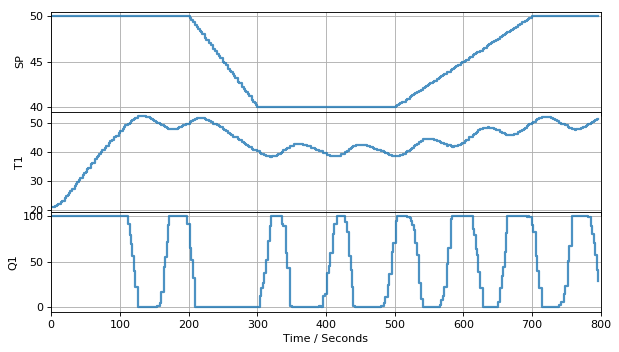

In [10]:
from tclab import setup, clock, Historian, Plotter
TCLab = setup(connected=False, speedup=20)

# create a controller instance
controller = PI(10, 4)
controller.send(None)

# execute the event loop
tf = 800
with TCLab() as lab:
    h = Historian([('SP', lambda: Tsp(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1)])
    p = Plotter(h, tf)
    for t in clock(tf, 2):
        T1 = lab.T1                      # take measurement
        SP = Tsp(t)                      # get setpoint
        U1 = controller.send([T1,SP,t])   # compute control action
        lab.U1 = U1                      # set manipulated variable  
        p.update(t)                      # log data